# Importing necessary packages

In [1]:
# Install OpenSlide and set the path to the installed directory below
OPENSLIDE_PATH = r'C:\\Github\\Prostate_Cancer_Grade_Assessment\\openslide-bin-4.0.0.2-windows-x64\\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [2]:
from openslide import OpenSlide
from typing import List, Dict, Tuple
import random
import numpy as np
import pandas as pd
import skimage.io
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import tqdm
import cv2
import glob
from tqdm.notebook import tqdm
from multiprocessing import Pool
from visual_helpers import plot_img_mask_details, create_big_image_from_tiles, create_tiles, \
    create_tiles_object_from_images, get_clipping_bounds, get_image_bounds_coverage


# Input Data Source
Set the path to the original PANDA dataset and required `.csv` files

In [3]:
DATASET_FOLDER_PATH: str = os.path.join(os.path.abspath('..'), 'dataset')
PANDA_DATASET_NAME: str = 'prostate-cancer-grade-assessment'
PANDA_DATASET_FOLDER_PATH: str = os.path.join(DATASET_FOLDER_PATH, PANDA_DATASET_NAME)
PANDA_IMAGE_FOLDER_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train_images')
PANDA_MASKS_FOLDER_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train_label_masks')
TRAIN_DATA_CSV_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train.csv')
TEST_DATA_CSV_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'test.csv')
SUSPICIOUS_DATA_CSV_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'suspicious_data.csv')

### Displaying the `train.csv` file

In [4]:
df_train_data: pd.DataFrame = pd.read_csv(TRAIN_DATA_CSV_PATH)
df_train_data.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


### Displaying the `suspicious_data.csv` file
Source: https://www.kaggle.com/code/dannellyz/collection-of-600-suspicious-slides-data-loader/notebook

In [5]:
df_suspicious_data: pd.DataFrame = pd.read_csv(SUSPICIOUS_DATA_CSV_PATH)
df_suspicious_data.head()

,image_id,reason
0,1866ab99cc028bbb8ed656f1181215f1,marks
1,3ad48056423f5a0710d13d943f112fe1,marks
2,eb62229279cd8ab73c9ca81171f14762,marks
3,ebc0cf09e9f77d222af0b8015c409a01,marks
4,d6b1c8ca6037b5ddca5d2086975a643b,marks


### Excluding suspicious image data from the PANDA dataset

In [6]:
print(f'Total number of images: {len(df_train_data.image_id.unique())}')
print(f'Total number of suspicious images: {len(df_suspicious_data.image_id.unique())}')

# Excluding data rows corresponding to suspicious/erroneous images
df_train_data = df_train_data.loc[~df_train_data.image_id.isin(df_suspicious_data.image_id.values)]
df_train_data = df_train_data.reset_index(drop=True).copy()
print(f'Total number of images (without suspicious images): {len(df_train_data.image_id.unique())}')

display(df_suspicious_data.groupby('reason').count())

Total number of images: 10616
Total number of suspicious images: 662
Total number of images (without suspicious images): 9954


,image_id
reason,
Background only,4
No Mask,100
No cancerous tissue but ISUP Grade > 0,85
blank,5
marks,475
tiss,6


Decision:

----------

The PANDA dataset has multiple annotation issues, including bad images with pen markings, images with missing masks, etc.
These images have been excluded from the training dataset to ensure the model learns from valid images more representative of the target.
Also, the testing set for this challenge has no images with pen markings, etc to keep it accurate for tetsing and comparision of different methods. 

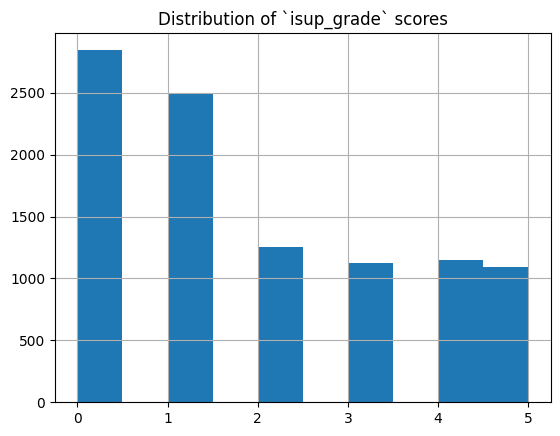

In [7]:
plt.figure()
df_train_data.isup_grade.hist()
plt.title('Distribution of `isup_grade` scores')
plt.show()

Decision:

----------

The distribution of ISUP grades in the PANDA dataset clearly shows that the dataset has twice the number of examples for scores `0`, `1` as comapred to scores `2`, `3`, `4` and `5`.
It will be important to use Stratified K-Fold Cross-Validation to make sure the model learns from data corresponding to a balanced class distribution during training.
If possible, it will ideal to train the model for multiple folds (preferably `5`) and compared the performance of the models on the hold-out testing set.

# Data Visualization

## Visualizing a sample slide image
Randomly displaying a TIFF image using OpenSlide

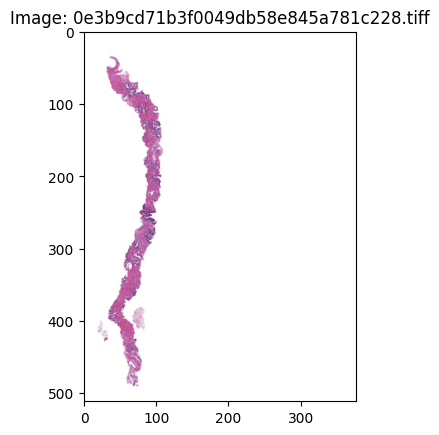

In [8]:
# Choosing a random slide image for viewing
num_total_images: int = len(df_train_data)
image_idx: int = random.randint(0, num_total_images)

# Loading the slide image using OpenSlide
slide_img: OpenSlide = openslide.OpenSlide(f'{PANDA_IMAGE_FOLDER_PATH}/{df_train_data.loc[image_idx].image_id}.tiff')

# Displaying the image as a 512x512 RGB image
plt.figure()
plt.imshow(slide_img.get_thumbnail(size=(512, 512)))
plt.title(f'Image: {df_train_data.loc[image_idx].image_id}.tiff')
plt.show()

## Visualizing a slide image with mask (overlayed)
Interactive widget to view a selected `image_id` along with its mask overlayed; displays TIFF metadata

In [9]:
# Loading the slide image using OpenSlide
def plot_something(selected_idx):
    selected_image_id: str = df_train_data.loc[selected_idx].image_id
    selected_data_provider: str = df_train_data.loc[selected_idx].data_provider

    selected_slide_img: OpenSlide = openslide.OpenSlide(f'{PANDA_IMAGE_FOLDER_PATH}/{selected_image_id}.tiff')
    selected_slide_mask: OpenSlide = openslide.OpenSlide(f'{PANDA_MASKS_FOLDER_PATH}/{selected_image_id}_mask.tiff')

    plot_img_mask_details(selected_slide_img, selected_slide_mask, data_source=selected_data_provider)

selected_idx = widgets.Dropdown(
    options=list(map(tuple, df_train_data[['image_id']].reset_index()[['image_id', 'index']].values)),
    description='Input TIFF File:',
)

interact(plot_something, selected_idx=selected_idx)

interactive(children=(Dropdown(description='Input TIFF File:', options=(('0005f7aaab2800f6170c399693a96917', 0…

<function __main__.plot_something(selected_idx)>

## Visualizing a suspicious slide image
Randomly displaying a suspicious TIFF image using OpenSlide

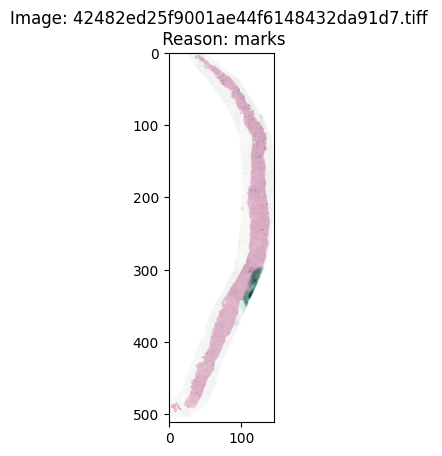

In [10]:
# Choosing a random slide image for viewing
num_total_images: int = len(df_suspicious_data)
image_idx: int = random.randint(0, num_total_images)

# Loading the slide image using OpenSlide
slide_img: OpenSlide = openslide.OpenSlide(f'{PANDA_IMAGE_FOLDER_PATH}/{df_suspicious_data.loc[image_idx].image_id}.tiff')

# Displaying the image as a 512x512 RGB image
plt.figure()
plt.imshow(slide_img.get_thumbnail(size=(512, 512)))
plt.title(f'Image: {df_suspicious_data.loc[image_idx].image_id}.tiff \n Reason: {df_suspicious_data.loc[image_idx].reason}')
plt.show()

## Visualizing images as tiles
Interactive widget to view images as different number of tiles obtained from different dimensions, tile sizes

In [11]:
def plot_something_2(selected_idx, level_dim, num_tiles, tile_size):
    selected_image_id: str = df_train_data.loc[selected_idx].image_id

    img: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_IMAGE_FOLDER_PATH, f'{selected_image_id}.tiff'))[level_dim]
    mask: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_MASKS_FOLDER_PATH, f'{selected_image_id}_mask.tiff'))[level_dim]
    
    x_b, y_b = get_clipping_bounds(img, perform_thresholding=True)
    img_clipped = img[x_b[0]:x_b[1], y_b[0]:y_b[1]]
    mask_clipped = mask[x_b[0]:x_b[1], y_b[0]:y_b[1]]
    
    tiles: List[Dict[any]] = create_tiles(img_clipped, mask_clipped, num_tiles, tile_size)
    big_img: np.ndarray = create_big_image_from_tiles(tiles, num_tiles, tile_size).astype(np.uint8)
    display(Image.fromarray(big_img))
    
# Dropdown widgets to image files/dimensions/number of tiles/tiel sizes
dd_selected_idx_2 = widgets.Dropdown(
    options=list(map(tuple, df_train_data[['image_id']].reset_index()[['image_id', 'index']].values)),
    description='Input TIFF File:',
)

dd_level_dims= widgets.Dropdown(options=[('', 2)], value=2, description='Level Dimensions:')
dd_num_tiles= widgets.Dropdown(options=[('16', 16), ('25', 25), ('36', 36)], value=16, description='Number of Tiles:')
dd_tile_sizes = widgets.Dropdown(options=[('128 x 128', 128), ('256 x 256', 256)], value=128, description='Tile Sizes:')

# Define a function that updates the content of y based on what we select for x
def update_1(*args):
    selected_image_id: str = df_train_data.loc[dd_selected_idx_2.value].image_id
    selected_slide_img: OpenSlide = openslide.OpenSlide(f'{PANDA_IMAGE_FOLDER_PATH}/{selected_image_id}.tiff')
    slide_level_dims: Tuple[Tuple[int, int]] = selected_slide_img.level_dimensions
    dd_level_dims.options = [(str(slide_level_dims[2]), 2), (str(slide_level_dims[1]), 1), (str(slide_level_dims[0]), 0)]
    dd_level_dims.value = 2
dd_selected_idx_2.observe(update_1)

interact(plot_something_2, selected_idx=dd_selected_idx_2, level_dim=dd_level_dims, num_tiles=dd_num_tiles, tile_size=dd_tile_sizes)

interactive(children=(Dropdown(description='Input TIFF File:', options=(('0005f7aaab2800f6170c399693a96917', 0…

<function __main__.plot_something_2(selected_idx, level_dim, num_tiles, tile_size)>

Decision:

----------

By creating tiles of different sizes from different resolutions present in the TIFF image,
I found that that 6 x 6 images of size 256 x 256 represented the slide optimally.
The tile size of 256 x 256 had the least white space when obtained with clipping, from the median resolution.

## Data source for the Tiled Dataset
Setting the source for the Tiled Dataset created from the Original PANDA dataset using `generate_tiled_dataset.py`

In [12]:
NUM_TILES: int = 36
TILE_SIZE: int = 256

TILED_DATASET_NAME: str = f'tiled-prostate-{NUM_TILES}x{TILE_SIZE}x{TILE_SIZE}'
TILED_DATASET_FOLDER_PATH: str = os.path.join(DATASET_FOLDER_PATH, TILED_DATASET_NAME)
TILED_IMAGE_FOLDER_PATH: str = os.path.join(TILED_DATASET_FOLDER_PATH, 'images')
TILED_MASKS_FOLDER_PATH: str = os.path.join(TILED_DATASET_FOLDER_PATH, 'masks')

To create a Hold-out Testing set and a Training set from the above dataset, use the file `create_holdout_test_set.py`

## Visualize the new tiled Dataset
Interactive widget to view all tiles of a selected `image_id` from the newly created Tiled dataset and view them as an `N x N` grid

In [13]:
def plot_something_3(selected_idx):
    selected_image_id: str = df_train_data.loc[selected_idx].image_id
    selected_data_provider: str = df_train_data.loc[selected_idx].data_provider

    list_tile_img_files: List[str] = [f'{selected_image_id}_{i}.png' for i in range(NUM_TILES)]
    list_tile_mask_files: List[str] = [f'{selected_image_id}_{i}.png' for i in range(NUM_TILES)]
    num_total_tiles: int = len(list_tile_img_files)
    
    list_tiles = create_tiles_object_from_images(TILED_DATASET_FOLDER_PATH, NUM_TILES,
                                                 list_tile_img_files, list_tile_mask_files,
                                                 include_mask=True)

    big_img: np.ndarray = create_big_image_from_tiles(list_tiles, num_total_tiles, list_tiles[0]['img'].shape[0]).astype(np.uint8)
    big_mask: np.ndarray = create_big_image_from_tiles(list_tiles, num_total_tiles, list_tiles[0]['img'].shape[0], 'mask').astype(np.uint8)
    display(Image.fromarray(big_img))
    
    big_mask = Image.fromarray(big_mask)
    preview_palette = np.zeros(shape=768, dtype=int)
    if selected_data_provider == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif selected_data_provider == 'karolinska':
        # Mapping: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
    big_mask.putpalette(data=preview_palette.tolist())
    big_mask = big_mask.convert(mode='RGB')
    display(big_mask)

# Dropdown wdget to select a TIFF file
dd_selected_idx_3 = widgets.Dropdown(
    options=list(map(tuple, df_train_data[['image_id']].reset_index()[['image_id', 'index']].values)),
    description='Input TIFF File:',
)

interact(plot_something_3, selected_idx=dd_selected_idx_3)

interactive(children=(Dropdown(description='Input TIFF File:', options=(('0005f7aaab2800f6170c399693a96917', 0…

<function __main__.plot_something_3(selected_idx)>

## Viewing any image/mask in any Dataset
Interactive widget to view an image or mask in any dataset folder

In [14]:
list_dataset_folders: List[str] = [(x, x) for x in os.listdir(DATASET_FOLDER_PATH)
                                   if os.path.isdir(os.path.join(DATASET_FOLDER_PATH, x))][::-1]

# Dropdowns for the interactive widget
dd_selected_ds_folder = widgets.Dropdown(options=list_dataset_folders, description='Dataset Folder:')
dd_selected_sub_folder = widgets.Dropdown(options=[('', '')], value='', description='Image or Mask?:')
dd_selected_file = widgets.Dropdown(options=[('', '')], value='', description='File Name:')

def plot_something_5(ds_folder_name, ds_sub_folder_name, file_name):    
    if file_name != '':
        image_file_path = os.path.join(DATASET_FOLDER_PATH, ds_folder_name, ds_sub_folder_name, file_name)
        
        img_extn = os.path.splitext(file_name)[1]
        
        if img_extn == '.tiff':
            try:
                image: np.ndarray = skimage.io.ImageCollection(image_file_path, conserve_memory=True)[-1]
                image = Image.fromarray(image)
                
                plt.figure()
                plt.imshow(image)
                plt.title(f'File: {file_name}')
                plt.show()
            except:
                print(image_file_path)
        else:
            if os.path.exists(image_file_path):
                image = Image.open(image_file_path)
                
                plt.figure()
                plt.imshow(image)
                plt.title(f'File: {file_name}')
                plt.show()

# Define a function that updates the content of y based on what we select for x
def update_1(*args):
    ds_folder_name: str = dd_selected_ds_folder.value
    ds_folder_path: str = os.path.join(DATASET_FOLDER_PATH, ds_folder_name)
    
    list_child_folders = [(x, x) for x in os.listdir(ds_folder_path)
                          if os.path.isdir(os.path.join(ds_folder_path, x))]
    dd_selected_sub_folder.options = list_child_folders
    dd_selected_sub_folder.value = list_child_folders[0][0]
    
    ds_folder_path: str = os.path.join(DATASET_FOLDER_PATH, ds_folder_name, list_child_folders[0][0])
    
    list_file_names_20 = os.listdir(ds_folder_path)[:20]
    dd_selected_file.options = list_file_names_20
    dd_selected_file.value = list_file_names_20[0]

dd_selected_ds_folder.observe(update_1)

interact(plot_something_5,
         ds_folder_name=dd_selected_ds_folder,
         ds_sub_folder_name=dd_selected_sub_folder,
         file_name=dd_selected_file)

interactive(children=(Dropdown(description='Dataset Folder:', options=(('train-tiled-prostate-36x256x256', 'tr…

<function __main__.plot_something_5(ds_folder_name, ds_sub_folder_name, file_name)>

# Image Processing using Morphological Operations

## Close clipping of slide images

This method uses the white pixels around all artifacts in the image slides to clip the images closely.
It converts the input image to binary 2D matrix of `1`s and `0`s and detect the corner co-ordinates of the blob formed by the `1` pixels.

Interactive widget to view clipped versions of TIFF images (clipping using the white background with/without thresholding)

In [15]:
def plot_something_4(selected_idx):
    level_dim = 2
    selected_image_id: str = df_train_data.loc[selected_idx].image_id

    # Loading the 2nd dimension image from the TIFF file
    og_img: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_IMAGE_FOLDER_PATH, f'{selected_image_id}.tiff'),
                                                    conserve_memory=True)[level_dim]

    new_size = (512, 512)
    plt.figure()
    plt.imshow(og_img)
    plt.title(f'Original image')
    plt.show()

    # Obtaining the clipping boundaries without thresholding
    x_b, y_b = get_clipping_bounds(og_img)
    og_img_all_clipped = og_img[x_b[0]:x_b[1], y_b[0]:y_b[1]]

    plt.figure()
    plt.imshow(np.array(og_img_all_clipped))
    plt.title(f'Clipped image (without thresholding)')
    plt.show()

    # Obtaining the clipping boundaries with thresholding
    x_b, y_b = get_clipping_bounds(og_img, perform_thresholding=True)
    og_img_all_clipped = og_img[x_b[0]:x_b[1], y_b[0]:y_b[1]]
    resized_clipped_img = Image.fromarray(og_img_all_clipped).resize(new_size)

    plt.figure()
    plt.imshow(np.array(og_img_all_clipped))
    plt.title(f'Clipped image (with thresholding)')
    plt.show()

    plt.figure()
    plt.imshow(np.array(resized_clipped_img))
    plt.title(f'Clipped image resized to {new_size}')
    plt.show()

dd_selected_idx_4 = widgets.Dropdown(
    options=list(map(tuple, df_train_data[['image_id']].reset_index()[['image_id', 'index']].values)),
    description='Input TIFF File:',
)

interact(plot_something_4, selected_idx=dd_selected_idx_4)

interactive(children=(Dropdown(description='Input TIFF File:', options=(('0005f7aaab2800f6170c399693a96917', 0…

<function __main__.plot_something_4(selected_idx)>

## Detecting white tiles and coverage percentage

The coverage percentage is the amount of overlap between the non-white region of an image with the whole image.
This percentage helps in determining how much portion of the image is actually made of white pixels (viz. `255`).
It has been used to reduce the number of white tiles when creating a larger tile by resampling tiles that had a minimum coverage percentage.

An image with a coverage percentage of `0%` is a white tile.

Clipping Bounds (without thresholding): ((0, 255), (64, 255))
Clipping Bounds (with thresholding): ((0, 198), (209, 255))
Coverage: 13.90%


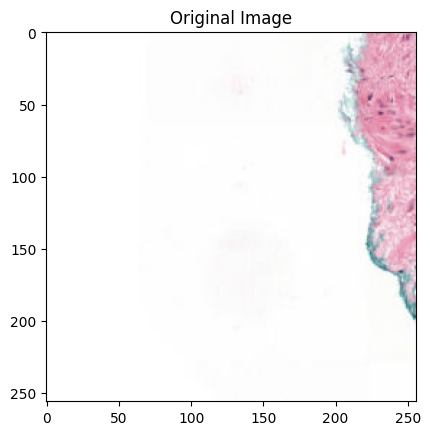

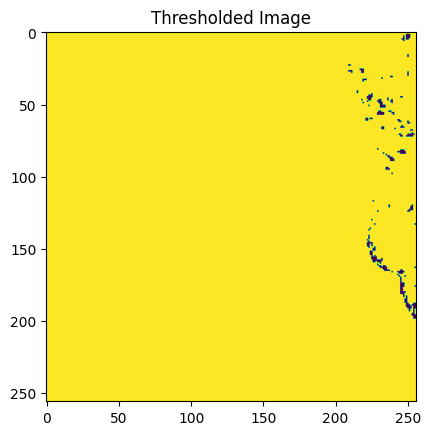

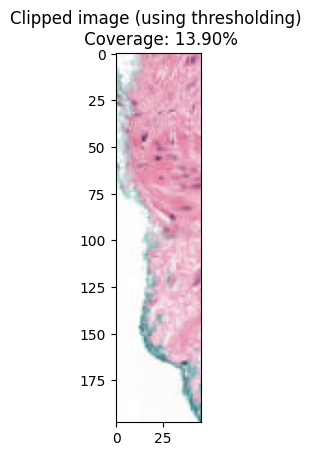

In [16]:
# Examples: Not Blank
# 00a7fb880dc12c5de82df39b30533da9_0.png

# Examples: Partial Blank
# 00a26aaa82c959624d90dfb69fcf259c_26.png
# 0a0f8e20b1222b69416301444b117678_26.png

# Examples: Blank
# 00a76bfbec239fd9f465d6581806ff42_34.png
# 0a0f8e20b1222b69416301444b117678_33.png
# 00a76bfbec239fd9f465d6581806ff42_32

# Loading a sample image
img_file_path = os.path.join(TILED_IMAGE_FOLDER_PATH, '0a0f8e20b1222b69416301444b117678_26.png')
og_np_img = cv2.imread(img_file_path)
og_np_img = cv2.cvtColor(og_np_img, cv2.COLOR_BGR2RGB)

# Converting the RGB image to a grayscale image
img_gs = cv2.cvtColor(og_np_img, cv2.COLOR_RGB2GRAY)
ret, th1 = cv2.threshold(img_gs, 150, 255, cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                            cv2.THRESH_BINARY, 11, 2)
th3 = cv2.adaptiveThreshold(img_gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY, 11, 2)

# Obtaining the clipping bounds and the coverage percentage
X_bounds, Y_bounds = get_clipping_bounds(og_np_img, perform_thresholding=True)
p_coverage: float = get_image_bounds_coverage(og_np_img, X_bounds, Y_bounds)

print(f'Clipping Bounds (without thresholding): {get_clipping_bounds(og_np_img)}')
print(f'Clipping Bounds (with thresholding): {(X_bounds, Y_bounds)}')
print(f'Coverage: {p_coverage:.2f}%')

plt.figure()
plt.imshow(og_np_img)
plt.title('Original Image')
plt.show()

plt.figure()
plt.imshow(th1)
plt.title('Thresholded Image')
plt.show()

plt.figure()
plt.imshow(og_np_img[X_bounds[0]:X_bounds[1], Y_bounds[0]:Y_bounds[1]])
plt.title(f'Clipped image (using thresholding) \n Coverage: {p_coverage:.2f}%')
plt.show()

## Detecting presence of pen markings

An attempt to remove pen markings from images to repurpose the slide images for training.
This morphological processing based method did not work effectively on all images.
Hence, images with pen markings have been excluded from the training dataset. 

In [17]:
def remove_pen_marks(img):
    
    # Define elliptic kernel
    kernel5x5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Convert image to gray scale and mask out background
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_mask = np.where(img_gray < 210, 1, 0).astype(np.uint8)
    
    # Reshape red channel into 1-d array, aims to mask most of the pen marks
    img_r = np.reshape(img[:, :, 0], (-1,))
    img_r = img_r[np.where(img_r < 255)[0]]
    img_r_mask = (img[:, :, 0] < np.median(img_r)-50).astype(np.uint8)

    # When computing the pen mark mask, some tissue gets masked as well,
    # thus needing to erode the mask to get rid of it. Then some dilatation is 
    # applied to capture the "edges" of the "gradient-like"/non-uniform pen marks
    img_r_mask = cv2.erode(img_r_mask, kernel5x5, iterations=3)
    img_r_mask = cv2.dilate(img_r_mask, kernel5x5, iterations=5)
    
    # Combine the two masks
    img_r_mask = 1 - img_r_mask
    img_mask = img_mask * img_r_mask
    
    # There might still be some gaps/holes in the tissue, here's an attempt to 
    # fill those gaps/holes
    img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_CLOSE, kernel5x5, iterations=1)
    img_mask = cv2.dilate(img_mask, kernel5x5, iterations=1)
    contours, _ = cv2.findContours(img_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(img_mask, [contour], 0, 1, -1)
    
    # Some final touch
    img_mask = cv2.erode(img_mask, kernel5x5, iterations=3)
    img_mask = cv2.dilate(img_mask, kernel5x5, iterations=1)
    img_mask = cv2.erode(img_mask, kernel5x5, iterations=2)
    
    # Mask out pen marks from original image
    img = img * img_mask[:, :, np.newaxis]
    
    return img, img_mask

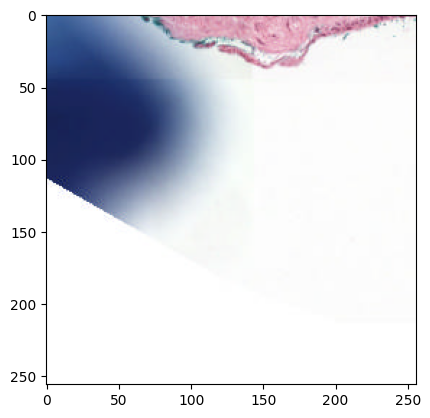

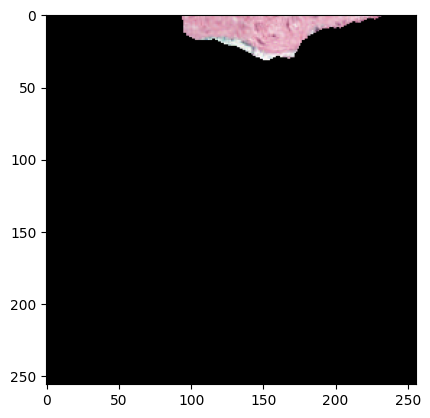

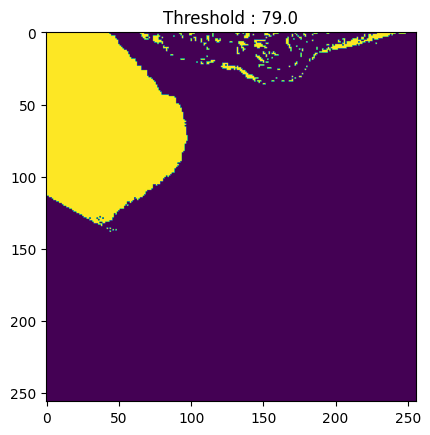

In [18]:
# Example tile images with pen markings (blue/green/black)
# 0ad4f3538ae67d99a7dbfcc01b2d2dd8_34.png
# 0b73719f81c77051bb4b0ece8647a48e_6.png
# 0b73719f81c77051bb4b0ece8647a48e_2.png
# 0c6c14ee4d822472a576f1f6650d79f0_6.png
# 0c6c14ee4d822472a576f1f6650d79f0_21.png
# 0c625807666551dc07436779d1969b24_1.png
# 0ad4f3538ae67d99a7dbfcc01b2d2dd8_0.png
# 0ad4f3538ae67d99a7dbfcc01b2d2dd8_25.png

img_file_name: str = '0ad4f3538ae67d99a7dbfcc01b2d2dd8_34.png'
img_file_path: str = os.path.join(TILED_IMAGE_FOLDER_PATH, img_file_name)

og_np_img = cv2.imread(img_file_path)
og_np_img = cv2.cvtColor(og_np_img, cv2.COLOR_BGR2RGB)

no_pen_img, no_pen_mask = remove_pen_marks(og_np_img)

hsv = cv2.cvtColor(og_np_img, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv) 
th, threshed = cv2.threshold(s, 100, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY)

plt.figure()
plt.imshow(og_np_img)
plt.show()

plt.figure()
plt.imshow(no_pen_img)
plt.show()

plt.figure()
plt.imshow(threshed)
plt.title(f"Threshold : {th}")
plt.show()

# Code Scratchpad

In [19]:
from datetime import datetime

tmp_og_img = og_np_img.copy()

if not True:
    # Setting background (white) to '0'
    tmp_og_img[tmp_og_img == 255] = 0
else:
    # Converting RGB image to Grayscale image
    tmp_gs_img = cv2.cvtColor(tmp_og_img, cv2.COLOR_RGB2GRAY)

    # Applying thresholding for improved image clipping
    th_val, thresh_img = cv2.threshold(tmp_gs_img, 150, 255, cv2.THRESH_BINARY)
    tmp_og_img[thresh_img == 0] = 1
    tmp_og_img[thresh_img == 255] = 0

# Setting all non-zero pixels to '1'
tmp_og_img[tmp_og_img > 0] = 1

# Converting 3-channel images to 1-channel
if tmp_og_img.ndim == 3:
    tmp_og_1c_img = np.max(tmp_og_img, axis=2)
else:
    tmp_og_1c_img = tmp_og_img.copy()

top_most_1_y = 0
bottom_most_1_y = 0
right_most_1_x = 0
left_most_1_x = 0

t1 = datetime.now()

# Finding the top and bottom y-locations where the blob is located in the image
all_1_y_idxs, _ = np.where(tmp_og_1c_img == 1)

if all_1_y_idxs.shape[0] > 0:
    top_most_1_y = all_1_y_idxs[0]
    bottom_most_1_y = all_1_y_idxs[-1]

    # Clipping the image from the top and bottom
    tmp_og_1c_img_clipped = tmp_og_1c_img[top_most_1_y:bottom_most_1_y, :].copy()

    # Finding the left and right x-locations where the blob is located in the image
    all_1_x_idxs, _ = np.where(tmp_og_1c_img_clipped.T == 1)

    if all_1_x_idxs.shape[0] > 0:
        right_most_1_x = all_1_x_idxs[0]
        left_most_1_x = all_1_x_idxs[-1]
    else:
        pass
else:
    pass

t2 = datetime.now()

print((top_most_1_y, bottom_most_1_y), (right_most_1_x, left_most_1_x))
print(f'np.where: {(t2.microsecond - t1.microsecond)} m-secs')

t3 = datetime.now()

num = 1
x_b_top = get_x_coord(tmp_og_1c_img, num)
x_b_bottom = get_x_coord(tmp_og_1c_img[::-1, ::-1], num)
y_b_left = get_x_coord(tmp_og_1c_img.T, num)
y_b_right = get_x_coord(tmp_og_1c_img.T[::-1, ::-1], num)

t4 = datetime.now()

print((x_b_top, x_b_bottom), (y_b_left, y_b_right))
print(f'np.argmax: {(t4.microsecond - t3.microsecond)} m-secs')



(0, 137) (0, 255)
np.where: 1000 m-secs


NameError: name 'get_x_coord' is not defined

In [ ]:
a = np.array([[4, 5, 7, 6],
              [3, 8, 4, 9],
              [9, 11, 66, 2],
              [7, 4, 1, 55]])

def get_x_coord(array, val):
    h, w = array.shape
    pos = np.argmax(array == val)
    x_pos = 0
    if pos > w:
        x_pos = (pos + 1) // h
        if (pos + 1) % h == 0:
            x_pos -= 1
    
    return x_pos

num = 11
x_b_top = get_x_coord(a, num)
x_b_bottom = get_x_coord(a[::-1, ::-1], num)
y_b_left = get_x_coord(a.T, num)
y_b_right = get_x_coord(a.T[::-1, ::-1], num)

print((x_b_top, x_b_bottom), (y_b_left, y_b_right))

(2, 1) (1, 2)


In [ ]:
list_tt = list(range(20))

from random import sample, shuffle

sample(list_tt, 3)

[3, 9, 19]

In [ ]:
shuffle(list_tt)

print(list_tt)

[6, 4, 14, 15, 18, 9, 11, 7, 2, 13, 16, 0, 8, 17, 1, 3, 12, 10, 5, 19]
